# Dynamic Environment Test with DynaQ and DynaQPlus
Gridworld where a shortcut opens up halfway through. 

* Position in the gridworld is the state
* Actions are compass moves between positions.
* Reward is 0 everywhere, except when reaching the goal, where it is 1

# Environment

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
class Maze:
    '''Class defining the environment'''
    def __init__(self, shapex, shapey, walls, start, goal):
        self.shapex = shapex
        self.shapey = shapey
        self.walls  = walls
        self.start  = start
        self.goal   = goal
        self.idx    = self.build_index()
        self.size   = shapex * shapey
        
        self.set_bitmap()
        self.original_walls = walls.copy()
        
    def reset_walls(self):
        self.walls  = self.original_walls
        self.set_bitmap()
        
    def state_from_index(self, number):
        '''get state from index'''
        x = number // self.shapey
        y = number  % self.shapey
        
        return (x, y)
        
    def build_index(self):
        '''build index for indexing states'''
        return {(x, y) : self.shapey * x + y for x in range(self.shapex) 
                for y in range(self.shapey)}
        
    def set_bitmap(self):
        '''builds the bitmap for visualisation'''
        bitmap = np.ones((self.shapex, self.shapey))
        
        for wall in self.walls:
            bitmap[wall] = 0
        
        self.bitmap = bitmap
    
    def show_bitmap(self):
        '''shows the environment of holes and walkable path'''
        plt.imshow(self.bitmap)
        
    def change(self, add=[], remove=[]):
        '''add or remove walls'''
        self.walls.extend([i for i in add])
        self.walls = [wall for wall in self.walls if wall not in remove]
        self.set_bitmap()

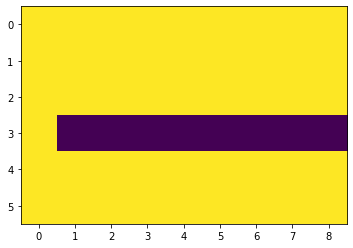

In [3]:
shapex = 6
shapey = 9
start  = (5, 5)
goal   = (0, 8)
walls  = [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8)]

shortcut = Maze(shapex, shapey, walls, start, goal)
shortcut.show_bitmap()

# Dyna-Q

In [4]:
class DynaQ:
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95):
        self.maze       = maze
        self.moves      = moves
        self.plan_steps = plan_steps
        self.alpha      = alpha
        self.epsilon    = epsilon
        self.gamma      = gamma
        self.move_idx   = {moves[i] : i for i in range(len(moves))}
    
    # --------------------------------------------DynaQ--------------------------------------------------#
    
    def reset(self):
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.history = [set()] * self.maze.size # History for planning part
        self.history_full = np.zeros(self.maze.size, dtype=bool)
            
    def step(self, S, A):
            
        Sn, R = self.move(S, A)

        # Only add to History if it isnt full yet
        if not self.history_full[self.maze.idx[S]]:
            self.history[self.maze.idx[S]].add(A)
            if len(self.history[self.maze.idx[S]]) == 4:
                self.history_full[self.maze.idx[S]] = 1
                
        self.visited = [i for i, h in enumerate(self.history) if h]
        
        return Sn, R
        
    def q_update(self, S, A, R, Sn):
        Am       = np.argmax(self.Q[S])
        idx      = (S[0],  S[1],  A)
        idxn     = (Sn[0], Sn[1], Am)
        self.Q[idx] += self.alpha * (R + self.gamma * self.Q[idxn] - self.Q[idx])
        
    def m_update(self, S, A, R, Sn):
        idx         = (S[0], S[1], A)
        self.M[idx] = R, Sn[0], Sn[1]
        
    def plan(self):
        for step in range(self.plan_steps):
            Spi = random.choice(self.visited)
            Sp  = self.maze.state_from_index(Spi)
            Ap  = random.choice(tuple(self.history[Spi]))
            Rp  = self.M[Sp[0], Sp[1], Ap, 0]
            Spn = tuple(self.M[Sp[0], Sp[1], Ap, 1:])
            
            self.q_update(Sp, Ap, Rp, Spn)
            
    def done(self, S):
        return S == self.maze.goal
    
    # --------------------------------------------Setup--------------------------------------------------#
    
    def move(self, S, A):
        # Clamp values to map
        direction = self.moves[A]
        
        Sx  = int(max(0, min(self.maze.shapex - 1, S[0] + direction[0])))
        Sy  = int(max(0, min(self.maze.shapey - 1, S[1] + direction[1])))
        Sn = (Sx, Sy)

        # Reset position if falling in hole
        if Sn in self.maze.walls:
            Sn = S

        R = 1 if Sn == self.maze.goal else 0

        return Sn, R
    
    def greedy(self, S):
        return np.argmax(self.Q[S])
    
    def epsilon_greedy(self, S):
        return np.argmax(self.Q[S]) if np.random.rand() > self.epsilon else np.random.randint(len(moves))
    
    def trace(self):
        S = self.maze.start
        path = []

        while not self.done(S):
            path.append(S)
            A    = self.greedy(S)
            S, _ = self.step(S, A)

            # Loop detection
            if S in path:
                print("State Values dont create greedy path")
                break

        return path
    
    # --------------------------------------------Image--------------------------------------------------#
    
    def create_best_path_img(self):
        path = self.trace()
        
        c0 = 5
        c1 = 6
        
        length    = len(path)
        grid      = self.maze.bitmap.copy()
        fade      = np.linspace(c0, c1, num=length)
        
        for i in range(length):
            grid[path[i]] = fade[i]
            
        grid[self.maze.start] = c0
        grid[self.maze.goal]  = c1
        
        print(f"path length: {length}")
        return grid
    
    def create_direction_map_img(self):
        arr_len    = 0.85
        grid       = self.create_best_path_img()
        directions = [((x, y), np.argmax(self.Q[x, y])) 
                      for x in range(self.maze.shapex) 
                      for y in range(self.maze.shapey)]   

        for i in directions:
            if i[0] not in self.maze.walls and i[0] != self.maze.goal:
                    dx = arr_len if i[1] == 2 else -arr_len if i[1] == 1 else 0 
                    dy = arr_len if i[1] == 3 else -arr_len if i[1] == 0 else 0
                    plt.arrow(i[0][1], i[0][0], dx, dy, head_width=0.1)

        return grid
    
    def draw_path_and_dir_map(self):
        plt.imshow(self.create_direction_map_img())

# DynaQPlus

In [5]:
class DynaQPlus(DynaQ):
    def __init__(self, maze, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=0.01):
        super().__init__(maze, moves, plan_steps, alpha, epsilon, gamma)
        self.k = k
        
    def reset(self):
        self.Q = np.random.rand(self.maze.shapex, self.maze.shapey, len(moves)) * 5
        self.M = np.zeros((self.maze.shapex, self.maze.shapey, len(moves), 3), dtype=int)
        self.T = np.zeros(self.maze.size)
        self.history      = [set()] * self.maze.size # History for planning part
        self.history_full = np.zeros(self.maze.size)
            
    def step(self, S, A):
        A     = self.epsilon_greedy(S)
        Sn, R = self.move(S, A)
        self.T[self.maze.idx[S]] = 0

        # Only add to History if it isnt full yet
        if not self.history_full[self.maze.idx[S]]:
            self.history[self.maze.idx[S]].add(A)
            if len(self.history[self.maze.idx[S]]) == 4:
                self.history_full[self.maze.idx[S]] = 1
                
        self.visited = [i for i, h in enumerate(self.history) if h]
        
        for i in self.visited:
            self.T[i] += 1
        
        return Sn, R
                
    def plan(self):
        for step in range(self.plan_steps):
            Spi = random.choice(self.visited)
            Sp  = self.maze.state_from_index(Spi)
            Ap  = random.choice(tuple(self.history[Spi]))
            Rp  = self.M[Sp[0], Sp[1], Ap, 0] + self.k * np.sqrt(self.T[Spi])
            Spn = tuple(self.M[Sp[0], Sp[1], Ap, 1:])
            
            self.q_update(Sp, Ap, Rp, Spn)

# Testing
Shortcut world, shortcut opens when we're halfway through the learning process

In [6]:
episodes = 2000
moves    = [(-1, 0), (0, -1), (0, 1), (1, 0)]
world    = shortcut

### DynaQ Run

path length: 18


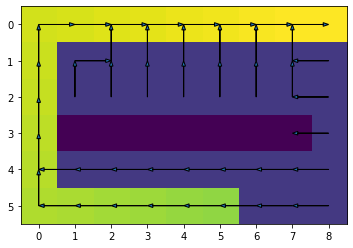

In [7]:
agent = DynaQ(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95)
agent.reset()    
world.reset_walls()
for episode in range(episodes):
    S = world.start
    
    if episode == episodes // 2:
        world.change(remove=[(3, 8)])

    while True:
        A     = agent.epsilon_greedy(S)
        Sn, R = agent.step(S, A)
        agent.q_update(S, A, R, Sn)
        agent.m_update(S, A, R, Sn)

        S = Sn
        agent.plan()
        
        if agent.done(S):
            break
agent.draw_path_and_dir_map();

### DynaQPlus Run

path length: 8


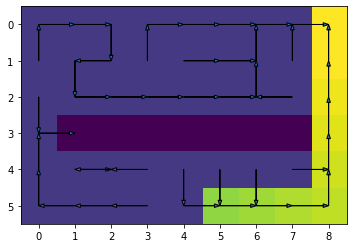

In [8]:
agent2 = DynaQPlus(world, moves, plan_steps=50, alpha=0.1, epsilon=0.1, gamma=0.95, k=0.00001)
agent2.reset()
world.reset_walls()
for episode in range(episodes):
    S = world.start
    
    if episode == episodes // 2:
        world.change(remove=[(3, 8)])

    while True:
        A     = agent2.epsilon_greedy(S)
        Sn, R = agent2.step(S, A)
        agent2.q_update(S, A, R, Sn)
        agent2.m_update(S, A, R, Sn)

        S = Sn
        agent2.plan()
        
        if agent2.done(S):
            break
agent2.draw_path_and_dir_map();

# Result
DynaQ doesn't find the newly opened shortcut, while DynaQPlus does